# COS 736 – Big Data Engineering  
**Capstone Project 2025**  
**Student:** Isaac Mtsweni  
**Project 1 – YouTube Trending Video Analysis**

In [236]:
%pip install --quiet "sqlalchemy>=2" pandas pymysql
print("deps ok")


Note: you may need to restart the kernel to use updated packages.
deps ok


**Question 1A (Batch Processing):**

In [ ]:
import pandas as pd
from sqlalchemy import create_engine, text

USER = "isaac"
PWD  = "MyStrongPwd!"   
HOST = "localhost"
PORT = 3307             
DB   = "4126704_US-YouTube_Trends"

# 2(b)(c) Creating the database 
# Step 1: connect to the server WITHOUT specifying a database
root_engine = create_engine(
    f"mysql+pymysql://{USER}:{PWD}@{HOST}:{PORT}/?charset=utf8mb4"
)

with root_engine.connect() as conn:
    conn.execute(text(f"CREATE DATABASE IF NOT EXISTS `{DB}`;"))
    print(f"✅ Database `{DB}` created / already exists.")



✅ Database `4126704_US-YouTube_Trends` created / already exists.


In [244]:
#2f and g
CSV_PATH = "USvideos.csv"   
TABLE    = "US_VIDEOS"

df = pd.read_csv(CSV_PATH, encoding="utf-8", low_memory=False)
print("rows, cols ->", df.shape)

df.to_sql(TABLE, engine, if_exists="replace", index=False)
print(f"✅ loaded {len(df):,} rows into {DB}.{TABLE}")


rows, cols -> (40949, 16)
✅ loaded 40,949 rows into 4126704_US-YouTube_Trends.US_VIDEOS


In [245]:
from sqlalchemy import text
pd.read_sql(text(f"SELECT COUNT(*) AS n FROM {TABLE};"), engine)

,n
0,40949


In [246]:
pd.read_sql(text(f"SELECT * FROM {TABLE} LIMIT 5;"), engine)


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,0,0,0,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,0,0,0,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,0,0,0,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,0,0,0,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,0,0,0,I know it's been a while since we did this sho...


**Q1A-3 Extraxt**

In [247]:
from sqlalchemy import text
import pandas as pd

TABLE = "US_VIDEOS"

with engine.connect() as conn:
    days_df = pd.read_sql(text(f"SELECT DISTINCT trending_date FROM {TABLE}"), conn)

days = sorted(days_df["trending_date"].dropna().astype(str).tolist())
print(f"Distinct days: {len(days)}")
days[:5]  # preview


Distinct days: 205


['17.01.12', '17.02.12', '17.03.12', '17.04.12', '17.05.12']

In [248]:
def extract_batches(engine, table=TABLE, days_list=None):
    """
    Yields (day, dataframe) where each dataframe contains ONLY rows for that day.
    Matches the 'one day per batch' for Q1A-3. 
    """
    if days_list is None:
        with engine.connect() as conn:
            _df = pd.read_sql(text(f"SELECT DISTINCT trending_date FROM {table}"), conn)
        days_list = sorted(_df["trending_date"].dropna().astype(str).tolist())

    for d in days_list:
        df = pd.read_sql(
            text(f"SELECT * FROM {table} WHERE trending_date = :d"),
            engine,
            params={"d": d},
        )
        yield d, df


In [249]:
for i, (day, batch) in enumerate(extract_batches(engine, TABLE, days[:3]), start=1):
    print(f"Batch {i}: day={day}  rows={len(batch)}")
    display(batch.head(2))


Batch 1: day=17.01.12  rows=200


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,6ZfuNTqbHE8,17.01.12,Marvel Studios' Avengers: Infinity War Officia...,Marvel Entertainment,24,2017-11-29T13:26:24.000Z,"marvel|""comics""|""comic books""|""nerdy""|""geeky""|...",56367282,2157727,34077,303178,https://i.ytimg.com/vi/6ZfuNTqbHE8/default.jpg,0,0,0,There was an idea… Avengers: Infinity War. In ...
1,nx1R-eHSkfM,17.01.12,The New Snapchat in 60 Seconds,Snapchat,10,2017-11-29T14:00:03.000Z,"new snapchat|""version 2""|""snap inc""|""brandnew""...",1894443,0,0,0,https://i.ytimg.com/vi/nx1R-eHSkfM/default.jpg,1,1,0,"Evan Spiegel, co-founder and CEO, explains the..."


Batch 2: day=17.02.12  rows=200


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,SM1w9PEQOE8,17.02.12,Demi Lovato - Tell Me You Love Me,DemiLovatoVEVO,10,2017-12-01T15:00:02.000Z,"Demi Lovato|""Tell Me You Love Me""|""Jesse Willi...",6296393,633622,8307,44548,https://i.ytimg.com/vi/SM1w9PEQOE8/default.jpg,0,0,0,Demi Lovato Tell Me You Love Me DELUXE: https:...
1,SA7AIQw-7Ms,17.02.12,G-Eazy & Halsey - Him & I (Official Video),GEazyMusicVEVO,10,2017-12-01T16:15:00.000Z,"BPG/RVG/RCA Records|""G-Eazy & Halsey""|""Him & I...",1554273,146680,1599,7305,https://i.ytimg.com/vi/SA7AIQw-7Ms/default.jpg,0,0,0,New Album ‘The Beautiful & Damned’ Available E...


Batch 3: day=17.03.12  rows=200


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,oX4YCoO6tK4,17.03.12,15 Toothpaste Life Hacks YOU SHOULD KNOW!,Wengie,26,2017-12-02T18:48:02.000Z,"wengie|""toothpaste""|""toothpaste hacks""|""you sh...",1048933,41411,2778,9055,https://i.ytimg.com/vi/oX4YCoO6tK4/default.jpg,0,0,0,Check out my NEW MUSIC VIDEO: https://youtu.be...
1,SM1w9PEQOE8,17.03.12,Demi Lovato - Tell Me You Love Me,DemiLovatoVEVO,10,2017-12-01T15:00:02.000Z,"Demi Lovato|""Tell Me You Love Me""|""Jesse Willi...",12310289,905712,15947,52780,https://i.ytimg.com/vi/SM1w9PEQOE8/default.jpg,0,0,0,Demi Lovato Tell Me You Love Me DELUXE: https:...


**Q1A-4 Transform**

In [251]:
from sqlalchemy import text
import pandas as pd

# --- date helper: '17.14.11'  ->  '2017-11-14'
def to_yyyy_mm_dd(trend_str: str) -> str:
    yy, dd, mm = str(trend_str).split(".")
    return f"20{yy}-{mm.zfill(2)}-{dd.zfill(2)}"

def transform_batch(df_raw: pd.DataFrame) -> pd.DataFrame:
    df = df_raw.copy()

    # 4c(i) Changing “trending_date” to YYYY-MM-DD date format.
    df["trending_date"] = df["trending_date"].astype(str).apply(to_yyyy_mm_dd)

    # 4c(ii) Separating “publish_time” into two columns named “publish_date” and “publish_time”.
    #       Published date should be in the format “YYYY-MM-DD”, while time should be “%H:%M:%S”
    ts = pd.to_datetime(df["publish_time"], errors="coerce")
    df["publish_date"] = ts.dt.strftime("%Y-%m-%d")
    df["publish_time"] = ts.dt.strftime("%H:%M:%S")

    # 4c(iii) After 4c(ii) above, drop the initial “publish_time”.
  
    # df.drop(columns=["publish_time"], inplace=True)

    # 4b — Title & Channel_title
    # 4b(iii) 
    df["Author"] = df["channel_title"]
    df["Title"]  = df["title"]          # make a canonical Title we can edit

    
    # original lower-case 'title' now that we created 'Title'
    if "title" in df.columns:
        df.drop(columns=["title"], inplace=True)

    # 4b(i) For music titles (category_id == 10), split the title into Artist Name and Song.
    #       Create two new columns “Artist” and “Title”. Delimiter is " - ".
    is_music = df["category_id"].astype(str) == "10"
    parts = df.loc[is_music, "Title"].astype(str).str.split(" - ", n=1, expand=True)
    if parts.shape[1] == 2:
        df.loc[is_music, "Artist"] = parts[0].str.strip()
        df.loc[is_music, "Title"]  = parts[1].str.strip()
    else:
        # ensuring column exists for schema consistency even if no splits happen in some batch
        if "Artist" not in df.columns:
            df["Artist"] = pd.NA

    # 4b(ii) For Celebrity Parody titles (category_id == 23), split on “|”.
    is_parody = df["category_id"].astype(str) == "23"
    p_mask = is_parody & df["Title"].astype(str).str.contains(r"\|")
    pparts = df.loc[p_mask, "Title"].astype(str).str.split("|", n=1, expand=True)
    if pparts.shape[1] == 2:
        df.loc[p_mask, "Author"] = pparts[0].str.strip()
        df.loc[p_mask, "Title"]  = pparts[1].str.strip()

    # 4d Drop columns not needed
    drop_cols = [
        "tags", "thumbnail_link", "ratings_disabled",
        "video_error_or_removed", "comments_disabled", "description"
    ]
    df.drop(columns=[c for c in drop_cols if c in df.columns], inplace=True)

    return df



In [252]:
# using the `extract_batches(...)` I wrote earlier
preview = []
for i, (day, batch) in enumerate(extract_batches(engine, table="US_VIDEOS", days_list=days[:3]), start=1):
    tdf = transform_batch(batch)
    preview.append((day, len(batch), len(tdf)))
    display(tdf.head(3))
print("Preview (day, rows_in, rows_out):", preview)


,video_id,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,publish_date,Author,Title,Artist
0,6ZfuNTqbHE8,2017-12-01,Marvel Entertainment,24,13:26:24,56367282,2157727,34077,303178,2017-11-29,Marvel Entertainment,Marvel Studios' Avengers: Infinity War Officia...,NaN
1,nx1R-eHSkfM,2017-12-01,Snapchat,10,14:00:03,1894443,0,0,0,2017-11-29,Snapchat,None,The New Snapchat in 60 Seconds
2,XbuQAbG2AZ0,2017-12-01,The New York Times,25,14:30:00,224270,7006,331,1127,2017-11-30,The New York Times,"Jay-Z and Dean Baquet, in Conversation",NaN


,video_id,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,publish_date,Author,Title,Artist
0,SM1w9PEQOE8,2017-12-02,DemiLovatoVEVO,10,15:00:02,6296393,633622,8307,44548,2017-12-01,DemiLovatoVEVO,Tell Me You Love Me,Demi Lovato
1,SA7AIQw-7Ms,2017-12-02,GEazyMusicVEVO,10,16:15:00,1554273,146680,1599,7305,2017-12-01,GEazyMusicVEVO,Him & I (Official Video),G-Eazy & Halsey
2,zJUtRGrvkqM,2017-12-02,The View,25,16:42:00,279827,3595,2770,3266,2017-12-01,The View,Flynn Promised 'Full Cooperation' To Mueller T...,NaN


,video_id,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,publish_date,Author,Title,Artist
0,oX4YCoO6tK4,2017-12-03,Wengie,26,18:48:02,1048933,41411,2778,9055,2017-12-02,Wengie,15 Toothpaste Life Hacks YOU SHOULD KNOW!,NaN
1,SM1w9PEQOE8,2017-12-03,DemiLovatoVEVO,10,15:00:02,12310289,905712,15947,52780,2017-12-01,DemiLovatoVEVO,Tell Me You Love Me,Demi Lovato
2,DQQN_79QrDY,2017-12-03,Hevesh5,24,18:00:00,458963,7099,450,843,2017-12-02,Hevesh5,"1,000,000 Dominoes Falling is Oddly SATISFYING",NaN


Preview (day, rows_in, rows_out): [('17.01.12', 200, 200), ('17.02.12', 200, 200), ('17.03.12', 200, 200)]


In [253]:
# 4f Repeat steps 4a–4e for all batches in the database.
total_rows = 0
for i, (day, batch) in enumerate(extract_batches(engine, table="US_VIDEOS", days_list=days), start=1):
    tdf = transform_batch(batch)   # 4a–4d
    load_per_category(tdf)         # 5a-5d
    total_rows += len(batch)
print(f"✅ Q1A finished: {i} batches, {total_rows:,} rows processed into Category_* tables.")


✅ Q1A finished: 205 batches, 40,949 rows processed into Category_* tables.


In [254]:
# 4e Passing the resulting dataframe to  Load function.
def load_per_category(df_t: pd.DataFrame):
    # Writing each transformed batch to Category_<category_id> table (append mode)

    for cat, g in df_t.groupby("category_id"):
        tname = f"Category_{int(cat)}" if pd.notna(cat) else "Category_NULL"
        g.to_sql(tname, engine, if_exists="append", index=False)



In [229]:
# A. List every table in my current database
import pandas as pd
pd.read_sql("SHOW TABLES;", engine)


,Tables_in_4126704_US-YouTube_Trends
0,Category_1
1,Category_10
2,Category_15
3,Category_17
4,Category_19
5,Category_2
6,Category_20
7,Category_22
8,Category_23
9,Category_24


In [230]:
import pandas as pd
from sqlalchemy import text

# listing Category_* tables
cats = pd.read_sql(
    text("SHOW TABLES LIKE :pat"),
    engine,
    params={"pat": r"Category\_%"}   
)

cats


,Tables_in_4126704_US-YouTube_Trends (Category\_%)
0,Category_1
1,Category_10
2,Category_15
3,Category_17
4,Category_19
5,Category_2
6,Category_20
7,Category_22
8,Category_23
9,Category_24


In [256]:
from sqlalchemy import text

tables = cats.iloc[:, 0].tolist()

rows = []
for t in tables:
    n = pd.read_sql(text(f"SELECT COUNT(*) AS n FROM `{t}`"), engine)["n"].iloc[0]
    rows.append((t, n))

pd.DataFrame(rows, columns=["table", "rows"]).sort_values("table")


,table,rows
0,Category_1,2345
1,Category_10,6472
2,Category_15,920
3,Category_17,2174
4,Category_19,402
5,Category_2,384
6,Category_20,817
7,Category_22,3210
8,Category_23,3457
9,Category_24,9964


**Question 1B (Inference & Insights)**

In [257]:
import pandas as pd
from sqlalchemy import text

def load_all_videos(engine) -> pd.DataFrame:
    try:
        #  view/table first
        return pd.read_sql(text("SELECT * FROM all_videos;"), engine)
    except Exception:
        
        cats = pd.read_sql(text("SHOW TABLES LIKE 'Category\\_%';"), engine)
        if cats.empty:
            raise RuntimeError(
                "No 'all_videos' view and no Category_* tables found. "
                "Run your Transform+Load step first."
            )
        frames = []
        for t in cats.iloc[:, 0]:
            frames.append(pd.read_sql(text(f"SELECT * FROM `{t}`;"), engine))
        return pd.concat(frames, ignore_index=True)

# Loading once 
df = load_all_videos(engine)

# Quick sanity peek
df.head(3)


,video_id,trending_date,channel_title,category_id,publish_time,views,likes,dislikes,comment_count,publish_date,Author,Title,Artist
0,ykHeGtN4m94,2017-12-01,20th Century Fox,1,21:28:53,2096711,49452,2641,4983,2017-11-28,20th Century Fox,"Love, Simon | Official Trailer [HD] | 20th Cen...",None
1,Z9cB0TjfIkM,2017-12-01,Screen Junkies,1,18:00:02,1827786,57103,955,5467,2017-11-28,Screen Junkies,Honest Trailers - The Room,None
2,a8gzChJsvEo,2017-12-01,CinemaSins,1,17:11:19,1614392,36163,3066,6371,2017-11-28,CinemaSins,Everything Wrong With Arrival In 16 Minutes Or...,None


In [258]:
#publish_time is time-only (HH:MM:SS) 
t = pd.to_datetime(df["publish_time"].astype(str), errors="coerce").dt.time

# Converting to seconds since midnight for easy binning
sec = pd.to_timedelta(
    pd.to_datetime(df["publish_time"].astype(str), errors="coerce").dt.strftime("%H:%M:%S")
).dt.total_seconds()

bins = [0, 6*3600, 12*3600, 18*3600, 24*3600]
labels = ["00:00–06:00", "06:00–12:00", "12:00–18:00", "18:00–24:00"]
df["_segment"] = pd.cut(sec, bins=bins, labels=labels, right=False, include_lowest=True)

uploads_by_segment = (
    df["_segment"].value_counts().reindex(labels).reset_index()
    .rename(columns={"index": "segment", "_segment": "uploads"})
)

print("Q1B.1 – uploads per 6-hr segment")
print(uploads_by_segment)
print("\nMost uploads:", uploads_by_segment.iloc[uploads_by_segment['uploads'].idxmax(), 0])
print("Fewest uploads:", uploads_by_segment.iloc[uploads_by_segment['uploads'].idxmin(), 0])


C:\Users\isaac\AppData\Local\Temp\ipykernel_34396\1516888673.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  t = pd.to_datetime(df["publish_time"].astype(str), errors="coerce").dt.time
C:\Users\isaac\AppData\Local\Temp\ipykernel_34396\1516888673.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df["publish_time"].astype(str), errors="coerce").dt.strftime("%H:%M:%S")


Q1B.1 – uploads per 6-hr segment
       uploads  count
0  00:00–06:00   7149
1  06:00–12:00   4023
2  12:00–18:00  17062
3  18:00–24:00  12715

Most uploads: 18:00–24:00
Fewest uploads: 00:00–06:00


In [259]:
# by total views
top3_views = (
    df.groupby("category_id", as_index=False)["views"].sum()
      .rename(columns={"views": "total_views"})
      .sort_values("total_views", ascending=False)
      .head(3)
)

# by count of videos
top3_counts = (
    df.groupby("category_id", as_index=False).size()
      .rename(columns={"size": "videos"})
      .sort_values("videos", ascending=False)
      .head(3)
)

print("Q1B.2a – Top 3 categories by total views")
print(top3_views)
print("\nQ1B.2b – Top 3 categories by number of videos")
print(top3_counts)


Q1B.2a – Top 3 categories by total views
   category_id  total_views
2           10  40132892190
9           24  20604388195
0            1   7284156721

Q1B.2b – Top 3 categories by number of videos
    category_id  videos
9            24    9964
2            10    6472
11           26    4146


In [260]:
total_rows = len(df)
distinct_videos = df["video_id"].nunique()
print(total_rows, distinct_videos)


40949 6351


In [261]:
cols_like = ["video_id", "Title", "Author", "publish_date", "likes"]
missing = [c for c in cols_like if c not in df.columns]
if missing:
    raise KeyError(f"Your data is missing columns needed for Q1B.3: {missing}")

most_liked = (
    df.loc[:, cols_like]
      .sort_values("likes", ascending=False)
      .drop_duplicates(subset=["video_id", "Title", "Author"], keep="first")
      .head(3)
      .reset_index(drop=True)
)

print("Q1B.3 – Most liked videos")
print(most_liked)


Q1B.3 – Most liked videos
      video_id                             Title               Author  \
0  7C2z4GqqS5E                              None              ibighit   
1  VYOjWnS4cMY  This Is America (Official Video)  ChildishGambinoVEVO   
2  ffxKSjUwKdU              No Tears Left To Cry     ArianaGrandeVevo   

  publish_date    likes  
0   2018-05-18  5613827  
1   2018-05-06  5023450  
2   2018-04-20  3094021  


In [262]:
cols_cmt = ["video_id", "Title", "Author", "publish_date", "comment_count"]
missing = [c for c in cols_cmt if c not in df.columns]
if missing:
    raise KeyError(f"Your data is missing columns needed for Q1B.4: {missing}")

most_commented = (
    df.loc[:, cols_cmt]
      .sort_values("comment_count", ascending=False)
      .drop_duplicates(subset=["video_id", "Title", "Author"], keep="first")
      .head(3)
      .reset_index(drop=True)
)

print("Q1B.4 – Most commented videos")
print(most_commented)


Q1B.4 – Most commented videos
      video_id                                              Title  \
0  QwZT7T-TXT0                                          So Sorry.   
1  7C2z4GqqS5E                                               None   
2  FlsCjmMhFmw  YouTube Rewind: The Shape of 2017 | #YouTubeRe...   

              Author publish_date  comment_count  
0   Logan Paul Vlogs   2018-01-02        1361580  
1            ibighit   2018-05-18        1228655  
2  YouTube Spotlight   2017-12-06         827755  


In [263]:
videos_per_cat = (
    df.groupby("category_id")["video_id"]
      .nunique()
      .reset_index(name="video_count")
      .sort_values("video_count", ascending=False)
)

print("QUESTION 1B.5 - VIDEOS PER CATEGORY")
print(videos_per_cat)


QUESTION 1B.5 - VIDEOS PER CATEGORY
    category_id  video_count
9            24         1622
2            10          801
11           26          595
8            23          547
10           25          507
7            22          498
4            17          452
13           28          381
0             1          321
12           27          251
3            15          141
6            20          103
1             2           71
5            19           60
14           29           14
15           43            4


In [276]:
videos_per_cat_all_rows = (
    df.groupby("category_id")
      .size()                                       # counts all rows, no dedupe
      .reset_index(name="video_count")
      .sort_values("video_count", ascending=False)
)

print("QUESTION 1B.5 (total appearances per category)")
print(videos_per_cat_all_rows)


QUESTION 1B.5 (total appearances per category)
    category_id  video_count
9            24         9964
2            10         6472
11           26         4146
8            23         3457
7            22         3210
10           25         2487
13           28         2401
0             1         2345
4            17         2174
12           27         1656
3            15          920
6            20          817
5            19          402
1             2          384
14           29           57
15           43           57


**Question 1C (Visualization)**

In [264]:
!pip install seaborn


In [265]:
print(type(uploads_by_segment))
print(uploads_by_segment.columns.tolist())
print(uploads_by_segment.head())



<class 'pandas.core.frame.DataFrame'>
['uploads', 'count']
       uploads  count
0  00:00–06:00   7149
1  06:00–12:00   4023
2  12:00–18:00  17062
3  18:00–24:00  12715


C:\Users\isaac\AppData\Local\Temp\ipykernel_34396\381279221.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=uploads_by_segment, x="segment", y="uploads", palette="coolwarm")


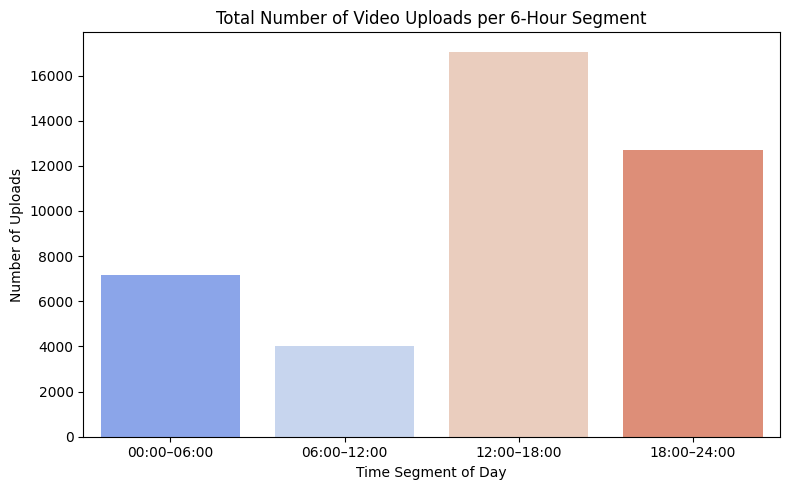

In [266]:
# Rename the columns to match what seaborn expects
uploads_by_segment = uploads_by_segment.rename(columns={
    "uploads": "segment",
    "count": "uploads"
})

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.barplot(data=uploads_by_segment, x="segment", y="uploads", palette="coolwarm")

plt.title("Total Number of Video Uploads per 6-Hour Segment")
plt.xlabel("Time Segment of Day")
plt.ylabel("Number of Uploads")
plt.tight_layout()
plt.show()


In [268]:
from sqlalchemy import text
import pandas as pd

q = text("""
SELECT category_id, COUNT(*) AS videos
FROM US_VIDEOS
GROUP BY category_id
ORDER BY videos DESC;
""")

videos_by_category = pd.read_sql(q, engine)


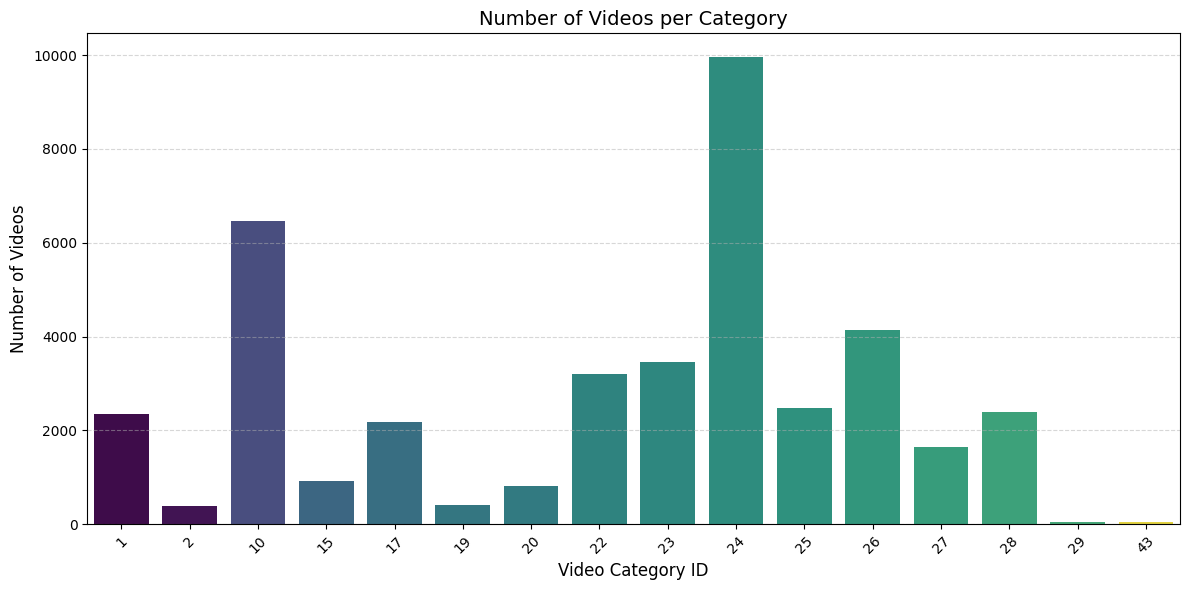

In [269]:
plt.figure(figsize=(12,6))
sns.barplot(
    data=videos_by_category,
    x="category_id",
    y="videos",
    hue="category_id",
    palette="viridis",
    legend=False
)

plt.title("Number of Videos per Category", fontsize=14)
plt.xlabel("Video Category ID", fontsize=12)
plt.ylabel("Number of Videos", fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [270]:
plt.savefig("Q1C2_VideosPerCategory.png", dpi=300)


<Figure size 640x480 with 0 Axes>

In [271]:
category_stats = (
    df.groupby("category_id")[["likes", "comment_count"]]
      .sum()
      .reset_index()
      .rename(columns={"likes": "total_likes", "comment_count": "total_comments"})
)



In [272]:
category_names = {
    1: "Film & Animation", 2: "Autos & Vehicles", 10: "Music",
    17: "Sports", 20: "Gaming", 22: "People & Blogs", 23: "Comedy",
    24: "Entertainment", 25: "News & Politics", 26: "Howto & Style",
    27: "Education", 28: "Science & Tech", 43: "Shows"
}

category_stats["category_name"] = category_stats["category_id"].map(category_names)


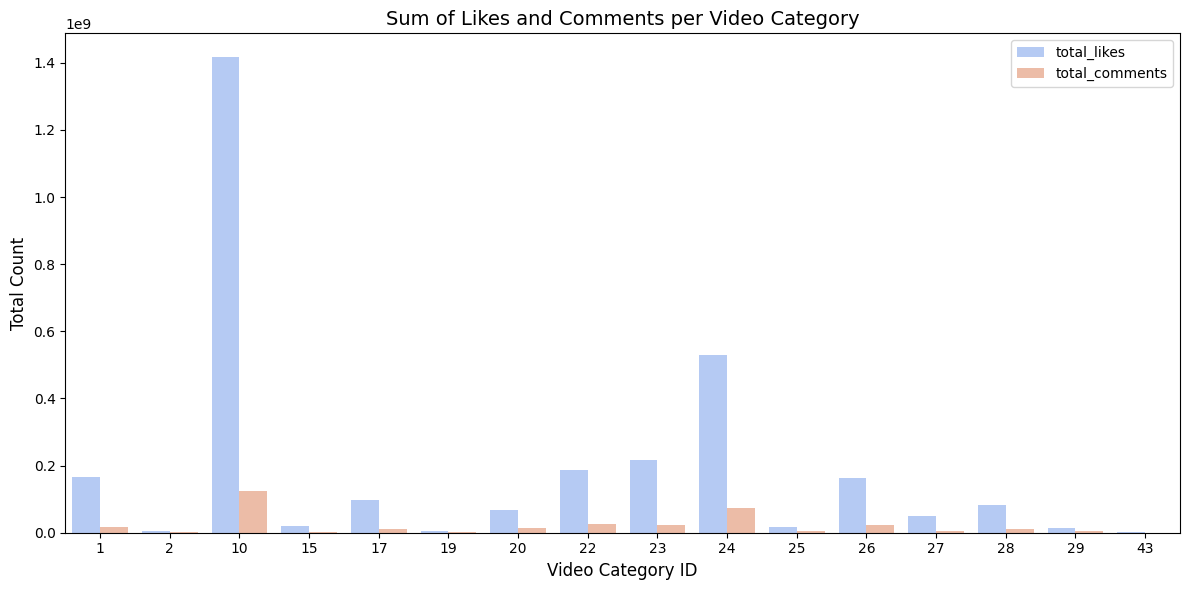

In [273]:
# assumes you already have an engine and the US_VIDEOS table

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import text

# 1) Get sums per category (likes & comments) from the DB
q = text("""
SELECT
  category_id,
  SUM(likes)         AS total_likes,
  SUM(comment_count) AS total_comments
FROM US_VIDEOS
GROUP BY category_id
ORDER BY category_id;
""")
category_stats = pd.read_sql(q, engine)

# 2) Long form for grouped bars
long_df = category_stats.melt(
    id_vars="category_id",
    value_vars=["total_likes", "total_comments"],
    var_name="Metric",
    value_name="Total"
)

# 3) Plot: grouped bars (two bars per category)
plt.figure(figsize=(12, 6))
sns.barplot(
    data=long_df,
    x="category_id",
    y="Total",
    hue="Metric",              # two bars per x
    palette="coolwarm"
)

plt.title("Sum of Likes and Comments per Video Category", fontsize=14)
plt.xlabel("Video Category ID", fontsize=12)
plt.ylabel("Total Count", fontsize=12)

# If the bars are very different in scale, a log y-axis helps:
# plt.yscale("log")

plt.xticks(rotation=0)
plt.legend(title="")
plt.tight_layout()
plt.show()


